# Data Pipeline Validation

This notebook validates the functions used in the data pipeline to prepare the datasets for model training and evaluation.  
Functions are included in the Python moduel **data_pipeline.py** located in the **src** folder.  

## 1. Setup

### 1.1 Imports

This section loads all necessary imports, including the functions from our **data_pipeline.py** module located in the **src** folder.

In [1]:
# Standard library imports
import math
import sys
import os
from pathlib import Path

In [ ]:
# Third party imports
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from sklearn.model_selection import train_test_split

In [3]:
# Custom imports (Data Pipeline functions)
sys.path.append(str(Path('../') / 'src'))
from data_pipeline import create_tf_dataset, create_preprocess_fn, translate_image, create_augment_fn, augment_dataset, format_for_model, train_dataset_assembly, test_dataset_assembly

### 1.2 Settings And Constants

This section sets global settings, defines global constants, and loads config files.

In [4]:
# Set project root directory as working directory for path consistency
os.chdir(Path('../').resolve())

# Pandas settings
pd.set_option('display.max_columns', None) # Display all columns

In [5]:
# Global constants
AUTOTUNE = tf.data.AUTOTUNE

In [6]:
# Load global config files
cfg = OmegaConf.merge(
    OmegaConf.load('configs/global.yaml'),
    OmegaConf.load('configs/augment.yaml'),
    OmegaConf.load('configs/backbone.yaml'))

### 1.3 Data Loading

This section generates (if needed) and loads the annotations CSV file containing the metadata from the dataset, and loads/creates the data splits for use during the pipeline validation.  
A mapping dict will also be created to translate the encoded labels to the original class names.

In [7]:
metadata_path = Path('data/capsule/annotations.csv')
if not metadata_path.is_file():
    print('Preprocessing MVTec Capsule dataset to CSV format...')
    !python3 scripts/preprocess_mvtec_to_csv.py
    print('Preprocessing complete.')
else:
    print('MVTec Capsule dataset CSV files already exist. Skipping preprocessing step.')
    metadata_df = pd.read_csv(metadata_path)
    print('Metadata CSV loaded as metadata_df dataframe.')

MVTec Capsule dataset CSV files already exist. Skipping preprocessing step.
Metadata CSV loaded as metadata_df dataframe.


In [8]:
# If splits exist, load them; otherwise, create them
raw_train_path = Path('data/capsule/raw_train.csv')
test_path = Path('data/capsule/test.csv')
if raw_train_path.is_file() and test_path.is_file():
    print('Loading existing train/test splits...')
    raw_train_df = pd.read_csv(raw_train_path)
    test_df = pd.read_csv(test_path)
    print('Raw_train and test splits loaded from CSV files.')
else:
    print('Creating new train/test splits...')
    raw_train_df, test_df = train_test_split(
        metadata_df,
        test_size=cfg.test_size,
        stratify=metadata_df['class_name'],
        random_state=cfg.SEED
    )
    print('Raw_train and test splits created based on config SEED and split ratio.')

Loading existing train/test splits...
Raw_train and test splits loaded from CSV files.


In [9]:
# Split training data into train and val sets
split_ratio = cfg.val_size / (1.0 - cfg.test_size) # Adjusted val size after test split
train_df, val_df = train_test_split(raw_train_df, test_size=split_ratio, random_state=cfg.SEED, stratify=raw_train_df['class_name'])

In [10]:
# Dict to map encoded label to class name
idx_to_class = dict(train_df[['label', 'class_name']].drop_duplicates().values)

### 1.4 Visualization Function

This section defines a visualiztion function to display both the image contained on the dataset and the image with the overlayed GT mask.  

In [11]:
def visualize_sample(dataset, class_decoder, num_samples=5) -> None:
    """
    Function to visualize samples from a TensorFlow dataset.
    Args:
        dataset: TensorFlow dataset (tf.data.Dataset)
        class_decoder: dict to map encoded labels to class names
        num_sample: number of samples to visualize
    """
    for image, label, mask in dataset.take(num_samples):
        image_np = image.numpy()
        mask_np = mask.numpy()

        # Normalize image for display
        if image_np.min() >= 0 and image_np.max() <= 1:
            disp_image = image_np  # [0,1] float
        elif image_np.min() >= 0 and image_np.max() > 1:
            disp_image = np.clip(image_np / 255.0, 0, 1)  # [0,255] float or uint8
        elif image_np.min() >= -1 and image_np.max() <= 1:
            disp_image = np.clip((image_np + 1) / 2, 0, 1)  # [-1,1] float
        else:
            raise ValueError('Unexpected image value range')
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        if label.numpy() != 0:
            axes[0].imshow(disp_image)
            axes[0].set_title('Image')
            axes[0].axis('off')
            axes[1].imshow(disp_image)
            axes[1].imshow(mask_np, cmap='cool', alpha=0.5)  # Overlay mask with some transparency
            axes[1].set_title(f'Label: {class_decoder[label.numpy()]}')
            axes[1].axis('off')
        else:
            axes[0].imshow(disp_image)
            axes[0].set_title('Image')
            axes[0].axis('off')
            axes[1].set_title(f'Label: {class_decoder[label.numpy()]} (No mask)')
            axes[1].axis('off')
        

        plt.tight_layout()
        plt.show()

## 2. Dataset Creation

This section evaluates the **create_tf_dataset** function of our pipeline.  
This function creates a dataset from a source dataframe, which will contain the following elements:  
**Args:**  
- df: (dataframe) Dataframe containing 'image_path', 'label' and 'mask_path' columns  

**Returns:**  
- dataset: (tf.data.Dataset) TensorFlow dataset object with the following elements  

**Dataset output:**  
- image_paths: (str) Paths to the original images  
- labels: (int32) Encoded GT class labels [0,5]  
- mask_paths: (str) Paths to the GT masks  

In [12]:
print('Dataframes sizes:')
print('Metadata dataframe size:', len(metadata_df))
print('Train dataframe size:', len(train_df))
print('Val dataframe size:', len(val_df))
print('Test dataframe size:', len(test_df))
print('Sum of train, val, and test sizes:', len(train_df) + len(val_df) + len(test_df))

Dataframes sizes:
Metadata dataframe size: 351
Train dataframe size: 245
Val dataframe size: 53
Test dataframe size: 53
Sum of train, val, and test sizes: 351


In [13]:
print(f'Image path: {train_df.iloc[0]['image_path']}')
print(f'Height: {cv2.imread(train_df.iloc[0]['image_path']).shape[0]}')
print(f'Width: {cv2.imread(train_df.iloc[0]['image_path']).shape[1]}')
print(f'Channels: {cv2.imread(train_df.iloc[0]['image_path']).shape[2]}')

Image path: data/capsule/train/good/202.png
Height: 1000
Width: 1000
Channels: 3


In [ ]:
raw_train_ds = create_tf_dataset(train_df)
raw_val_ds = create_tf_dataset(val_df)

In [15]:
print('\nDataset sizes:')
print('Train dataset size:', raw_train_ds.cardinality().numpy())
print('Val dataset size:', raw_val_ds.cardinality().numpy())


Dataset sizes:
Train dataset size: 245
Val dataset size: 53


Dataframes and datasets match in number of samples.

Next content of the dataset will be evaluated for a 'good' and a defective sample

In [16]:
print('Data validation of a "good" sample after dataset creation:')
good_sample = next(iter(raw_train_ds.filter(lambda img, label, mask: label == 0).take(1)))
image, label, mask = good_sample
print('Image path:', image)  # Should be str and a valid path
print('Label:', label.numpy(), '-> dtype:', label.dtype)  # Should be int32
print('Mask path:', mask)  # Should be str 'no_mask'

print('\nData validation of a defect sample after dataset creation:')
defect_sample = next(iter(raw_train_ds.filter(lambda img, label, mask: label != 0).take(1)))
image, label, mask = defect_sample
print('Image path:', image)  # Should be str and a valid path
print('Label:', label.numpy(), '-> dtype:', label.dtype)  # Should be int32
print('Mask path:', mask)  # Should be str and a valid path

Data validation of a "good" sample after dataset creation:
Image path: tf.Tensor(b'data/capsule/train/good/202.png', shape=(), dtype=string)
Label: 0 -> dtype: <dtype: 'int32'>
Mask path: tf.Tensor(b'no_mask', shape=(), dtype=string)

Data validation of a defect sample after dataset creation:
Image path: tf.Tensor(b'data/capsule/test/faulty_imprint/021.png', shape=(), dtype=string)
Label: 2 -> dtype: <dtype: 'int32'>
Mask path: tf.Tensor(b'data/capsule/ground_truth/faulty_imprint/021_mask.png', shape=(), dtype=string)


## 3. Image preprocessing

This section evaluates the **create_preprocess_fn** factory function of our pipeline.  
The generated function is designed to read image, resize, handle mask presence, and return tensors.  

After generating **preprocess_sample**, said function can be applied directly via '.map()'.  

**Dataset outputs before preprocessing:**  
- image_path (tf.Tensor): Path to the image file.
- label (tf.Tensor): Integer label for the image.
- mask_path (tf.Tensor): Path to the mask file, or 'no_mask' if no mask exists.

**Dataset outputs after preprocessing:**  
- image (tf.Tensor): Preprocessed image tensor of shape [H, W, 3].
- label (tf.Tensor): Integer label tensor.
- mask (tf.Tensor): Preprocessed mask tensor of shape [H, W, 1] (generated empty mask if it does not exist)

First, the input size used for resizing in the preprocessing function is added manually to the config object.  
Usually this is included in the model/experiment config file.  

In [17]:
# Add 'input_size' to cfg
OmegaConf.update(cfg, 'input_size', (300,300))

Second, the factory function is executed to generate a preprocessing function which is then applied to the dataset.  

In [18]:
preprocess_sample = create_preprocess_fn(cfg)
preproc_train_ds = raw_train_ds.map(preprocess_sample, num_parallel_calls=AUTOTUNE).cache()

In [19]:
print('Data validation of a "good" sample after preprocessing:')
good_sample = next(iter(preproc_train_ds.filter(lambda img, label, mask: label == 0).take(1)))
image, label, mask = good_sample
print('Label:', label.numpy(), '-> dtype:', label.dtype)  # Should be int32
print('Image shape:', image.shape)  # Should be (300, 300, 3)
print('Mask shape:', mask.shape)  # Should be (300, 300, 1)
print('Image Pixel min/max:', tf.reduce_min(image), tf.reduce_max(image)) # Should be in [0.0, 255.0] and float32
print('Mask Pixel min/max:', tf.reduce_min(mask), tf.reduce_max(mask)) # Should be 0.0 and 0.0 (should have only black pixels) and float32

print('\nData validation of a defect sample after preprocessing:')
defect_sample = next(iter(preproc_train_ds.filter(lambda img, label, mask: label != 0).take(1)))
image, label, mask = defect_sample
print('Label:', label.numpy(), '-> dtype:', label.dtype)  # Should be int32
print('Image shape:', image.shape)  # Should be (300, 300, 3)
print('Mask shape:', mask.shape)  # Should be (300, 300, 1)
print('Image Pixel min/max:', tf.reduce_min(image), tf.reduce_max(image)) # Should be in [0.0, 255.0] and float32
print('Mask Pixel min/max:', tf.reduce_min(mask), tf.reduce_max(mask)) # Should be 0.0 and 1.0 (should have black and white pixels) and float32

2025-11-26 19:41:54.385100: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Data validation of a "good" sample after preprocessing:
Label: 0 -> dtype: <dtype: 'int32'>
Image shape: (300, 300, 3)
Mask shape: (300, 300, 1)
Image Pixel min/max: tf.Tensor(13.0, shape=(), dtype=float32) tf.Tensor(253.19443, shape=(), dtype=float32)
Mask Pixel min/max: tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)

Data validation of a defect sample after preprocessing:
Label: 2 -> dtype: <dtype: 'int32'>
Image shape: (300, 300, 3)
Mask shape: (300, 300, 1)
Image Pixel min/max: tf.Tensor(15.0, shape=(), dtype=float32) tf.Tensor(231.72253, shape=(), dtype=float32)
Mask Pixel min/max: tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


2025-11-26 19:41:54.446964: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Before moving on to the next step of the pipeline, a visualization function is defined to inspect visually some images after preprocessing.

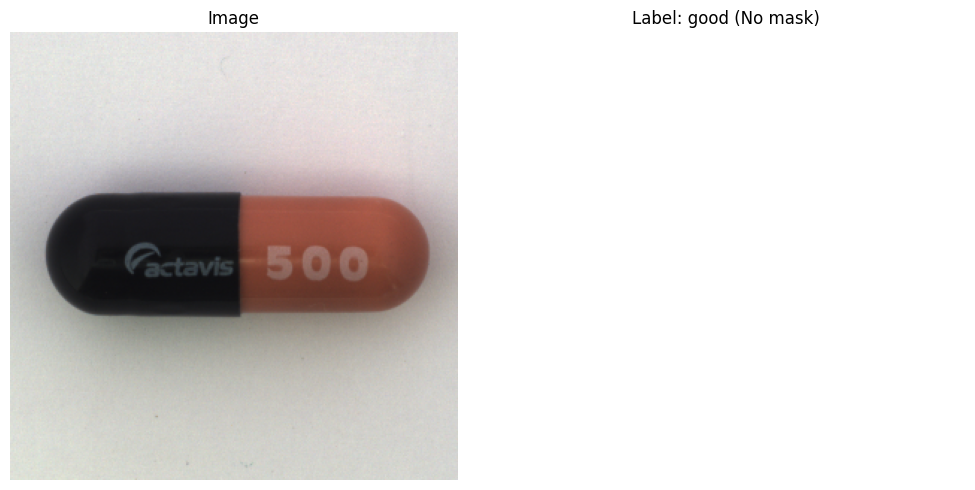

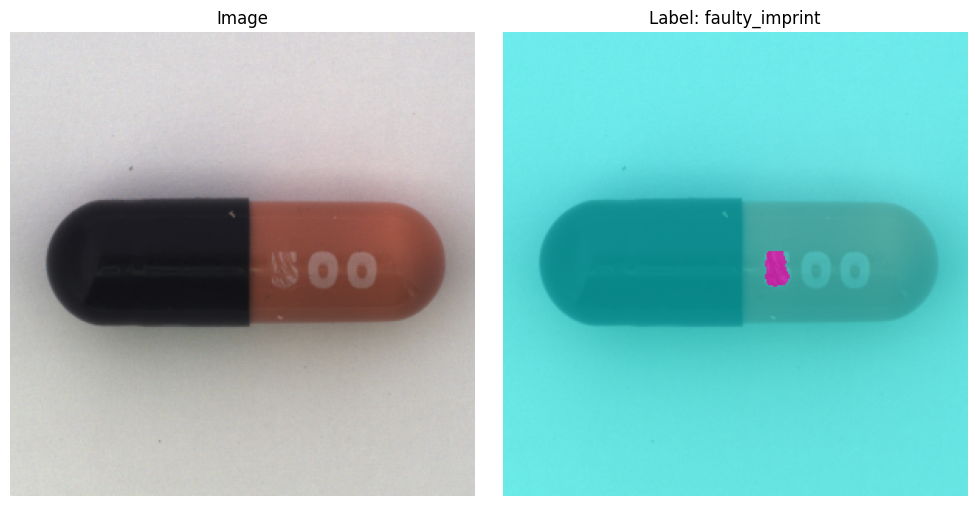

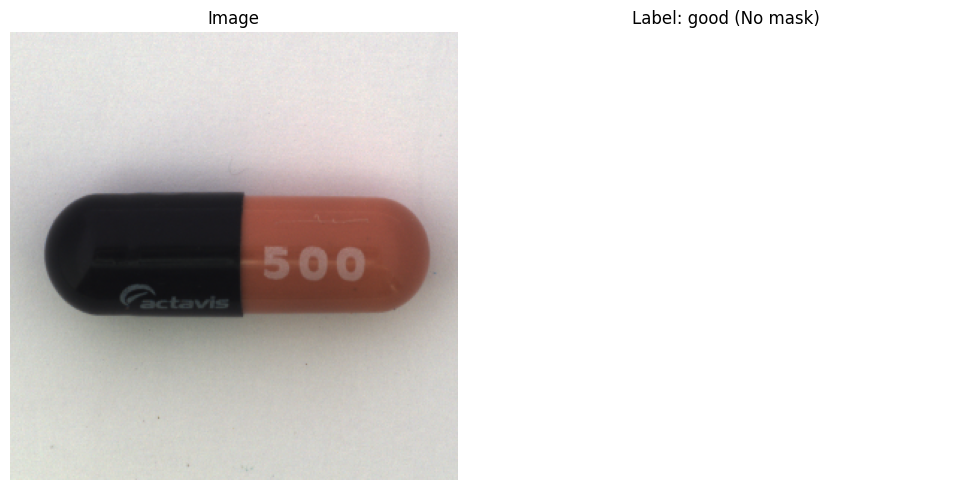

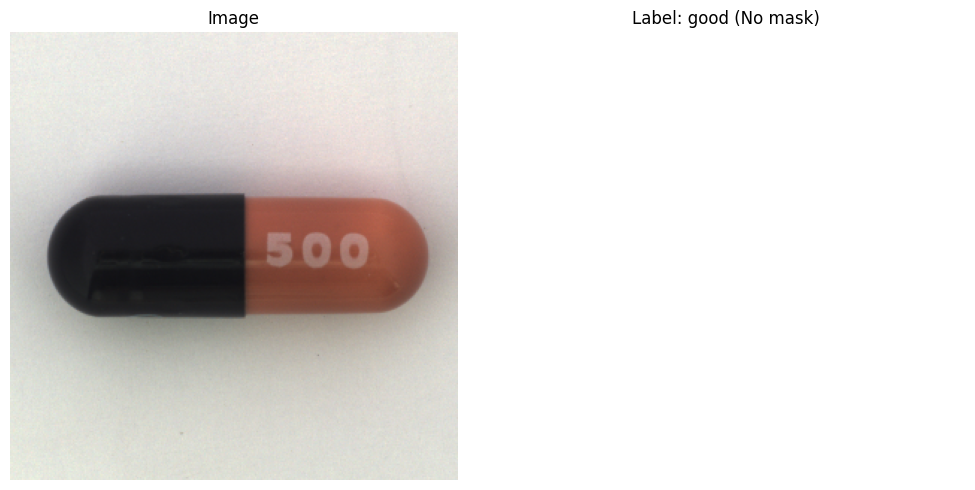

2025-11-26 19:41:55.035835: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


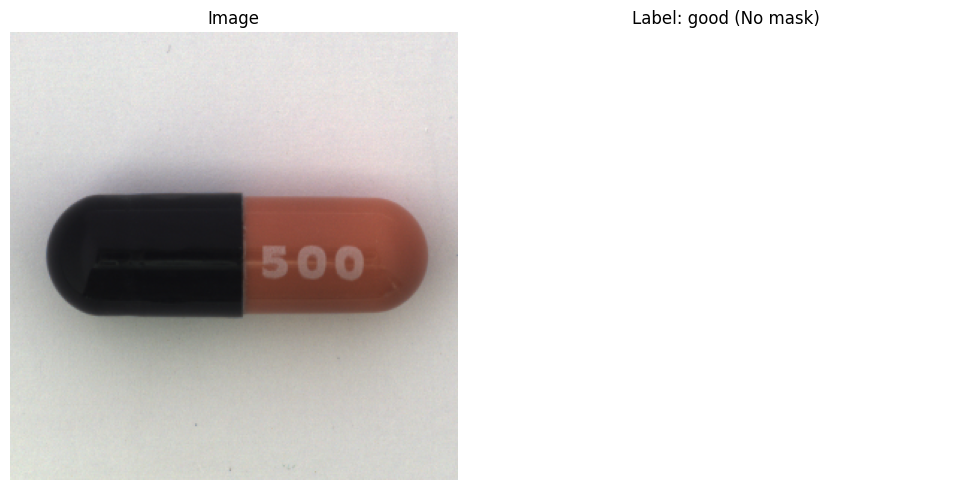

2025-11-26 19:41:55.208559: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
visualize_sample(preproc_train_ds, idx_to_class, num_samples=5) # Visualize only one sample to keep notebook lightweight

## 4. Data Augmentation

This section validates the augmentation stage of the data pipeline.  

Because the original dataset is imbalanced (dominated by 'good' samples), the augmentation applied to 'good' samples (light_augment_fn) is different from the augmentation applied to defective samples (aggressive_augment_fn).

The rate of augmentation is defined in the config file **configs/augment.yaml** which also contains other augmentation settings.  

Several functions are defined for the operation:
- **light_augment_fn:** applies random changes on brightness and contrast, plus random vertical flips
- **aggressive_augment_fn:** applies random changes on brightness, contrast, saturation and hue, plus random vertical flips and small translations
- **create_augment_fn:** factory function to apply the augmentation functions depending on the class
- **augment_dataset:** makes use of the previous function using a probabilistic approach to create a new dataset made of augmented samples, and returns the result of concatenating the original dataset and the generated one.

All transformations applied over images are standard **Tensorflow.image** operations, with the exception of the translation used in the aggressive_augmentation_fn as there is no available function in TF for it.  

As such an auxiliary function called **translate_image** is defined using **Tensorflow raw_ops**. Before validating the augmentation process, a small validation check is applied to this custom transformation function:

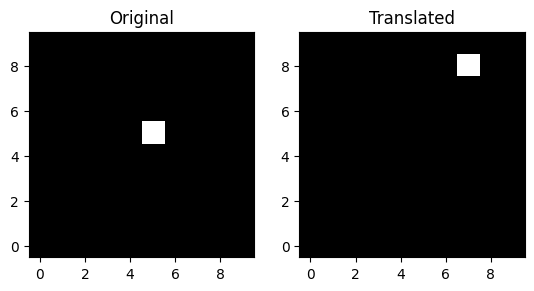

In [21]:
# Create a simple synthetic image: 10x10 black with a white pixel at (5,5)
img = np.zeros((10, 10, 1), dtype=np.float32)
img[5, 5, 0] = 1.0
tf_img = tf.convert_to_tensor(img)

# Translate the image by 2 pixels right, 3 pixels up
translated_img = translate_image(tf_img, dx=2, dy=3, fill_mode='REFLECT', interpolation='BILINEAR').numpy()

# Visualize
plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(img.squeeze(), cmap='gray', origin='lower')
plt.subplot(1, 2, 2)
plt.title('Translated')
plt.imshow(translated_img.squeeze(), cmap='gray', origin='lower')
plt.show()

After validating the translation function, the augment stage of the pipeline will be validated by reviewing that:
- number of samples match the expected augmentation
- format and data types of elements have not changed
- visually no unexpected artifacts are present

In [22]:
good_count = int((train_df['label'] == 0).sum())
defect_count = int((train_df['label'] != 0).sum())
approx_train_samples = int(good_count * (float(cfg.MULTIPLIER_GOOD) + 1.0) + defect_count * (float(cfg.MULTIPLIER_DEFECT) + 1.0))

# Data augmentation
cfg.REPEAT_FACTOR = int(math.ceil(max(float(cfg.MULTIPLIER_GOOD), float(cfg.MULTIPLIER_DEFECT)))) # Override repeat factor based on max multiplier to ensure enough samples
augmented_train_ds = augment_dataset(preproc_train_ds, cfg)
print(f'Approximate number of training samples after augmentation: {approx_train_samples}')

Approximate number of training samples after augmentation: 1025


In [23]:
# Due to the lazy nature of tf.data.Dataset, we need to iterate through the dataset to get its size, but this is only done once for verification purposes.
print('Augmented train dataset size:', len(list(augmented_train_ds))) # Should be approximately the same as the previous theretical calculation

Augmented train dataset size: 1045


2025-11-26 19:41:56.431411: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [24]:
print('Data validation of a "good" sample after data augmentation:')
good_sample = next(iter(augmented_train_ds.filter(lambda img, label, mask: label == 0).take(1)))
image, label, mask = good_sample
print('Label:', label.numpy(), '-> dtype:', label.dtype)  # Should be int32
print('Image shape:', image.shape)  # Should be (300, 300, 3)
print('Mask shape:', mask.shape)  # Should be (300, 300, 1)
print('Image Pixel min/max:', tf.reduce_min(image), tf.reduce_max(image)) # Should be in [0.0, 255.0] and float32
print('Mask Pixel min/max:', tf.reduce_min(mask), tf.reduce_max(mask)) # Should be 0.0 and 0.0 (should have only black pixels) and float32
print('\nData validation of a defect sample after data augmentation:')
defect_sample = next(iter(augmented_train_ds.filter(lambda img, label, mask: label != 0).take(1)))
image, label, mask = defect_sample
print('Label:', label.numpy(), '-> dtype:', label.dtype)  # Should be int32
print('Image shape:', image.shape)  # Should be (300, 300, 3)
print('Mask shape:', mask.shape)  # Should be (300, 300, 1)
print('Image Pixel min/max:', tf.reduce_min(image), tf.reduce_max(image)) # Should be in [0.0, 255.0] and float32
print('Mask Pixel min/max:', tf.reduce_min(mask), tf.reduce_max(mask)) # Should be 0.0 and 1.0 (should have black and white pixels) and float32

Data validation of a "good" sample after data augmentation:
Label: 0 -> dtype: <dtype: 'int32'>
Image shape: (300, 300, 3)
Mask shape: (300, 300, 1)
Image Pixel min/max: tf.Tensor(13.0, shape=(), dtype=float32) tf.Tensor(253.19443, shape=(), dtype=float32)
Mask Pixel min/max: tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)

Data validation of a defect sample after data augmentation:
Label: 2 -> dtype: <dtype: 'int32'>
Image shape: (300, 300, 3)
Mask shape: (300, 300, 1)
Image Pixel min/max: tf.Tensor(15.0, shape=(), dtype=float32) tf.Tensor(231.72253, shape=(), dtype=float32)
Mask Pixel min/max: tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


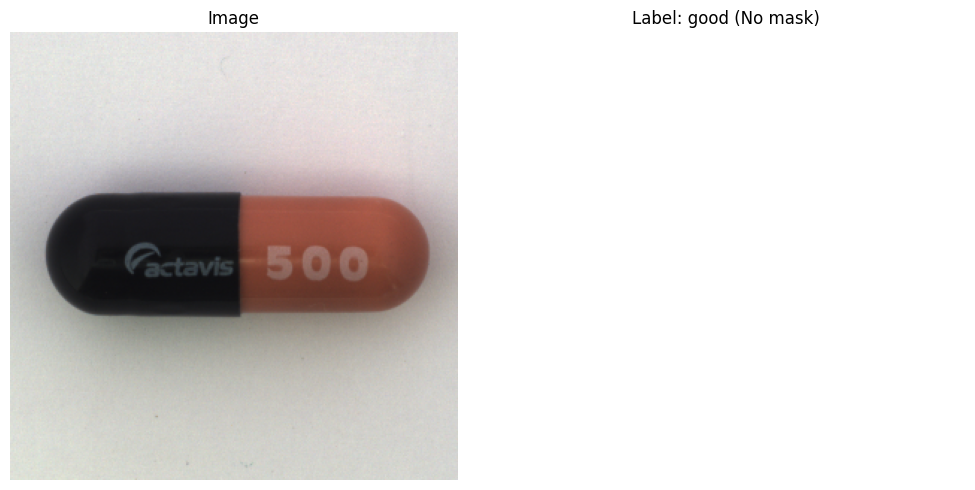

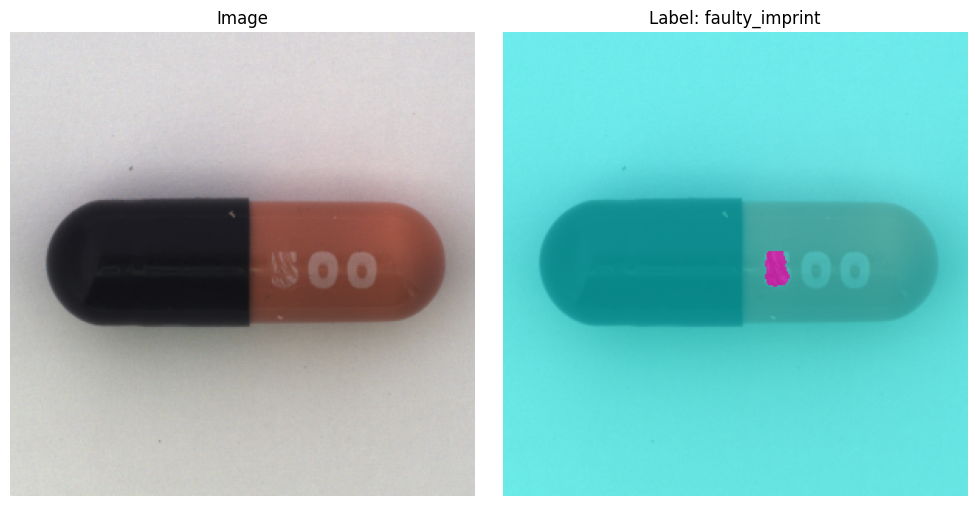

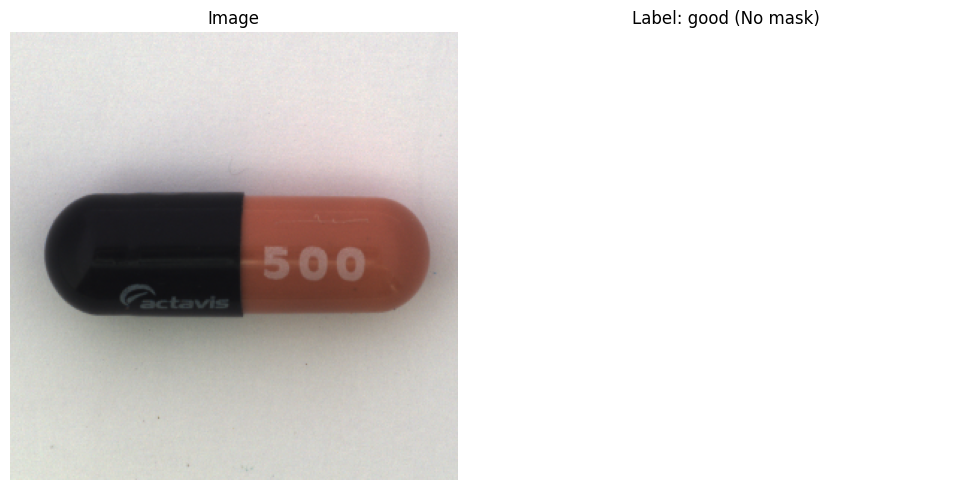

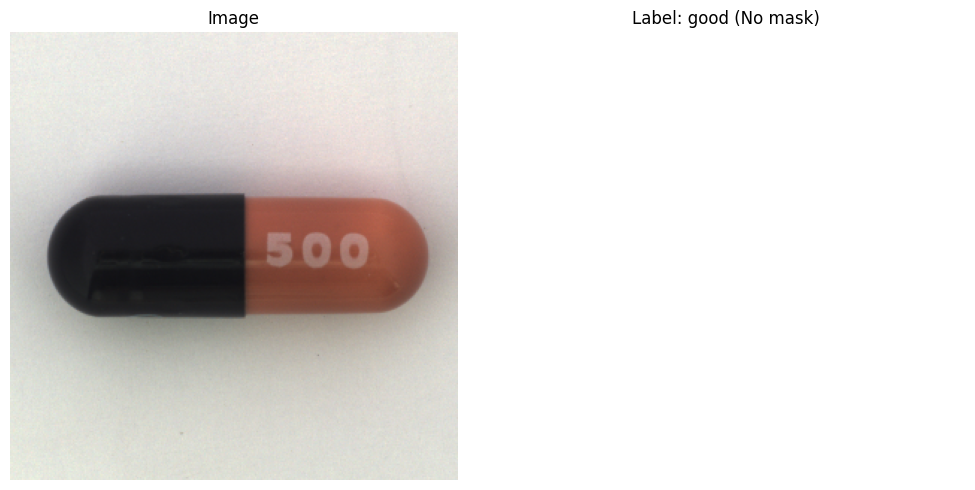

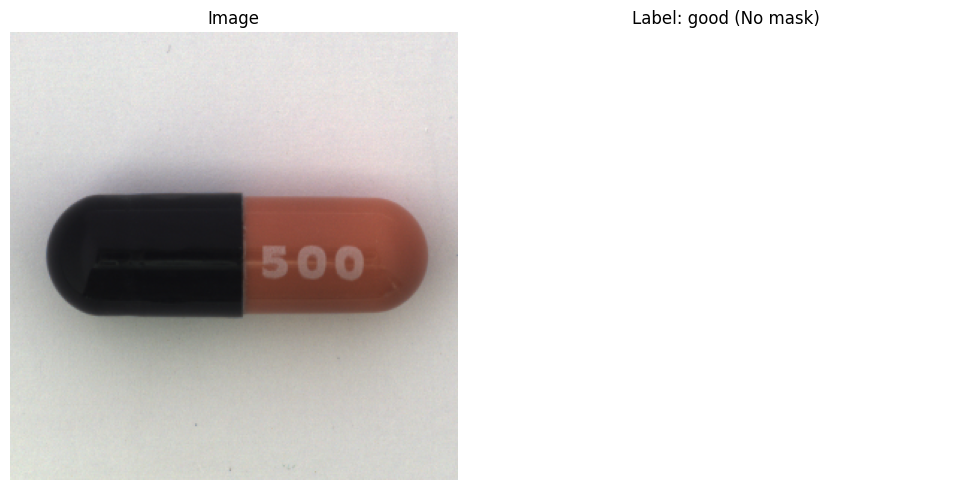

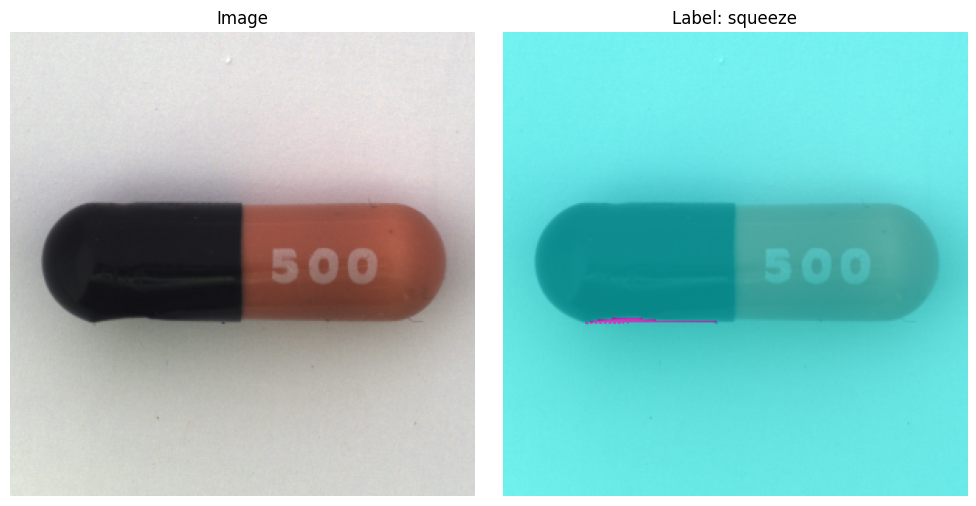

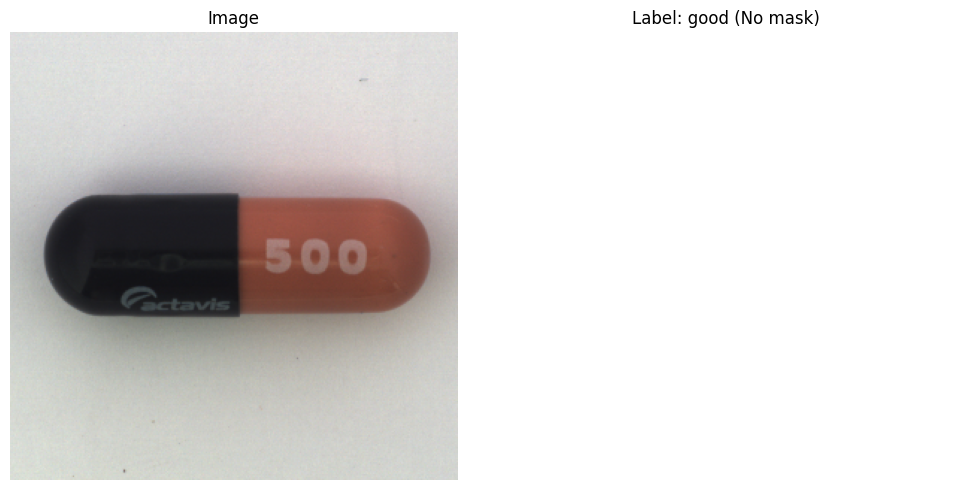

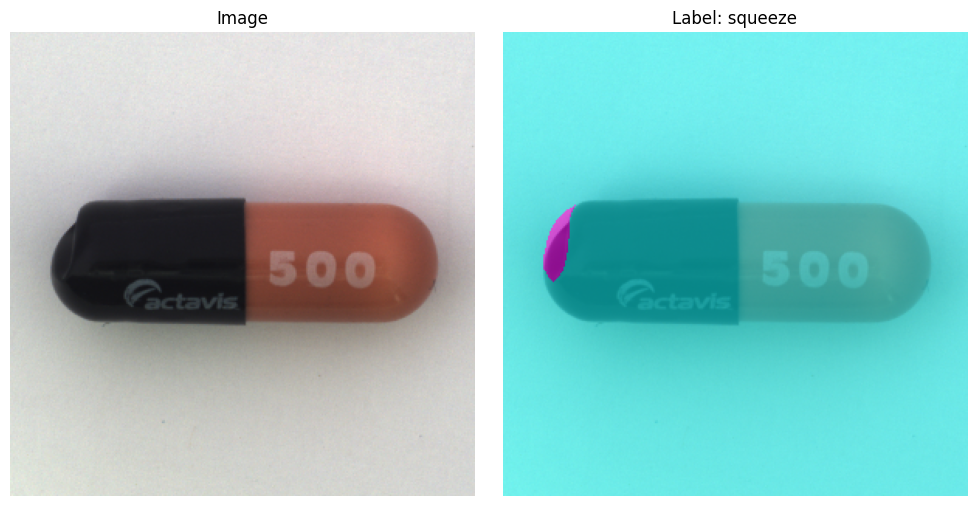

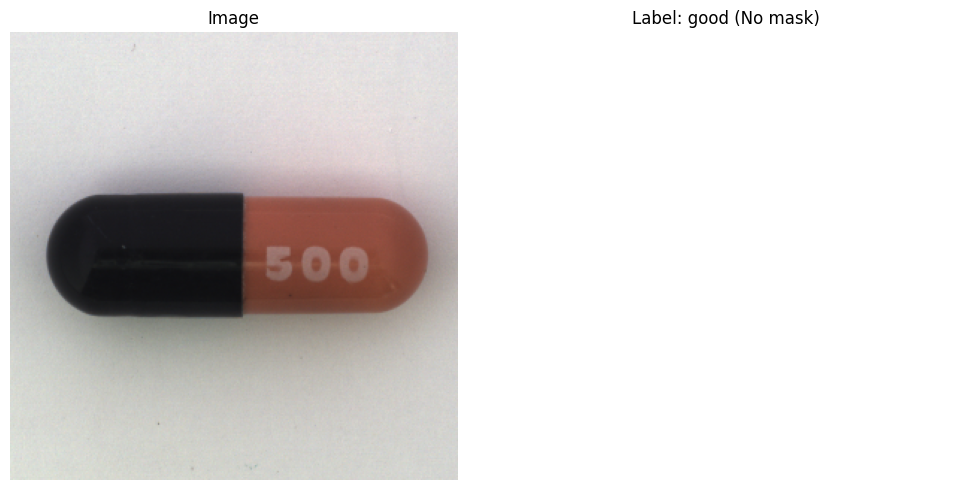

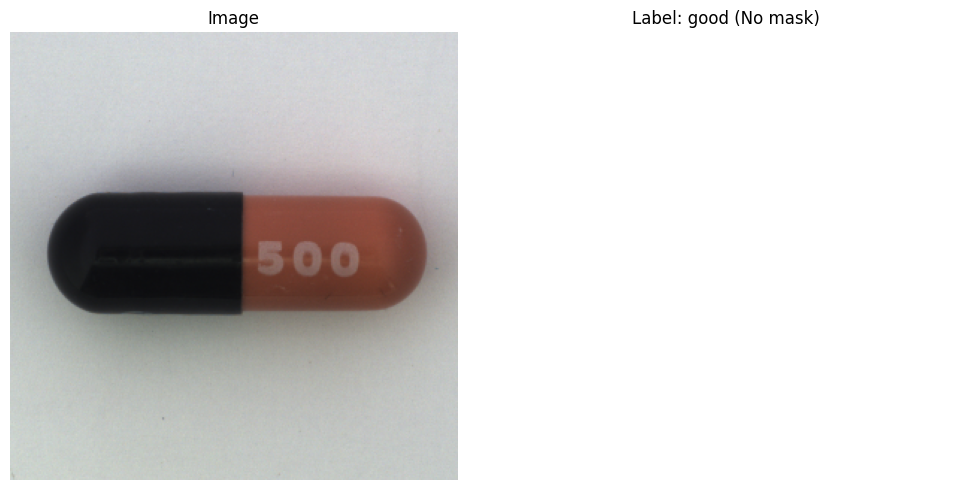

In [25]:
# Visualize samples only from the augmented dataset, before concatenating, to ensure we see only augmented samples.
visualize_sample(augmented_train_ds, idx_to_class, num_samples=10) # Visualize only one sample to keep notebook lightweight

## 5. Data Format

For easier handling the dataset format during all these operations was a 3 element tuple (image, label, mask), however the model expects a two element tuple (x,y).  

To match the dataset output with the model expectations, a format function **format_for_model** is defined that only changes the format in which the dataset generates elements.  

From (image, label, mask) to (image, targets), with targets being a dict {'label': label, 'mask': mask}.  

The three elements still hold the same data type and shape:  
- image (tf.Tensor): Image tensor of shape [H, W, 3] in float32 with pixels normalized in [0, 255].
- label (tf.Tensor): Integer label tensor.
- mask (tf.Tensor): Mask tensor of shape [H, W, 1] (generated empty mask if it does not exist) in float32 with binary values (0.0, 1.0).

In [26]:
formatted_augmented_train_ds = augmented_train_ds.map(format_for_model, num_parallel_calls=AUTOTUNE).cache()

In [27]:
# Inspect the new format 
sample = next(iter(formatted_augmented_train_ds.take(1)))
image, target = sample
print('Type of image:', type(image)) # Should be a Tensor
print('Type of target:', type(target), '\n') # Should be dict

print('Target keys:', target.keys() if isinstance(target, dict) else 'Not a dict') # Should be [label, mask]

print('Label type:', type(target['label']) if isinstance(target, dict) and 'label' in target else "No 'label' key") # Should be a Tensor
print('Mask type:', type(target['mask']) if isinstance(target, dict) and 'mask' in target else "No 'mask' key") # Should be a Tensor

Type of image: <class 'tensorflow.python.framework.ops.EagerTensor'>
Type of target: <class 'dict'> 

Target keys: dict_keys(['label', 'mask'])
Label type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Mask type: <class 'tensorflow.python.framework.ops.EagerTensor'>


2025-11-26 19:41:57.873493: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [28]:
print('Data validation of a "good" sample after dataset formatting:')
good_sample = next(iter(formatted_augmented_train_ds.filter(lambda img, target: target['label'] == 0).take(1)))
image, target = good_sample
label = target['label']
mask = target['mask']
print('Label:', label.numpy(), '-> dtype:', label.dtype)  # Should be int32
print('Image shape:', image.shape)  # Should be (300, 300, 3)
print('Mask shape:', mask.shape)  # Should be (300, 300, 1)
print('Image Pixel min/max:', tf.reduce_min(image), tf.reduce_max(image)) # Should be in [0.0, 255.0] and float32
print('Mask Pixel min/max:', tf.reduce_min(mask), tf.reduce_max(mask)) # Should be 0.0 and 0.0 (should have only black pixels) and float32
print('\nData validation of a defect sample after dataset formatting:')
defect_sample = next(iter(formatted_augmented_train_ds.filter(lambda img, target: target['label'] != 0).take(1)))
image, target = defect_sample
label = target['label']
mask = target['mask']
print('Label:', label.numpy(), '-> dtype:', label.dtype)  # Should be int32
print('Image shape:', image.shape)  # Should be (300, 300, 3)
print('Mask shape:', mask.shape)  # Should be (300, 300, 1)
print('Image Pixel min/max:', tf.reduce_min(image), tf.reduce_max(image)) # Should be in [0.0, 255.0] and float32
print('Mask Pixel min/max:', tf.reduce_min(mask), tf.reduce_max(mask)) # Should be 0.0 and 1.0 (should have black and white pixels) and float32

Data validation of a "good" sample after dataset formatting:
Label: 0 -> dtype: <dtype: 'int32'>
Image shape: (300, 300, 3)
Mask shape: (300, 300, 1)
Image Pixel min/max: tf.Tensor(13.0, shape=(), dtype=float32) tf.Tensor(253.19443, shape=(), dtype=float32)
Mask Pixel min/max: tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)

Data validation of a defect sample after dataset formatting:
Label: 2 -> dtype: <dtype: 'int32'>
Image shape: (300, 300, 3)
Mask shape: (300, 300, 1)
Image Pixel min/max: tf.Tensor(15.0, shape=(), dtype=float32) tf.Tensor(231.72253, shape=(), dtype=float32)
Mask Pixel min/max: tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


2025-11-26 19:41:57.911516: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-11-26 19:41:57.937509: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## 6. Assembly Function

For easier use, two assembly functions are defined.

**train_dataset_assembly** takes 3 inputs (train and validation dataframes, plus the config) and returns 3 outputs (train and validation datasets, plus the approximate number of samples on the train dataset).  

To the train dataset, preprocessing, augmentation and format are applied, plus shuffle(), repeat(), batch(), and prefetch().

To the val dataset, preprocessing and format are applied, plus batch() and prefetch().

These two datasets can be directly used for model training.  


**test_dataset_assembly** takes only one dataframe and the config object, and applies the same process as the one for the val dataset described in the previous function.  

In [29]:
train_ds, val_ds, approx_train_samples = train_dataset_assembly(train_df, val_df, cfg)

In [30]:
batch = next(iter(train_ds))  # Get a batch
batch_images, batch_targets = batch

print('Batch images shape:', batch_images.shape) # Should be (batch_size, 300, 300, 3)
print('Type of batch_targets:', type(batch_targets)) # Should be a dict
print('Batch target keys:', batch_targets.keys() if isinstance(batch_targets, dict) else 'Not a dict') # Should be [label, mask]
print('Label batch shape:', batch_targets['label'].shape if 'label' in batch_targets else "No 'label' key") # Should be (batch_size,)
print('Mask batch shape:', batch_targets['mask'].shape if 'mask' in batch_targets else "No 'mask' key") # Should be (batch_size, 300, 300, 1)

Batch images shape: (16, 300, 300, 3)
Type of batch_targets: <class 'dict'>
Batch target keys: dict_keys(['label', 'mask'])
Label batch shape: (16,)
Mask batch shape: (16, 300, 300, 1)


In [31]:
print('\nData validation of the first "good" sample in the batch after assembly:')
idx_good = tf.where(batch_targets['label'] == 0)[0][0]  # Get index of a 'good' sample (label == 0)
image = batch_images[idx_good]
label = batch_targets['label'][idx_good]
mask = batch_targets['mask'][idx_good]

print('Label:', label.numpy(), '-> dtype:', label.dtype)  # Should be int32
print('Image shape:', image.shape)  # Should be (300, 300, 3)
print('Mask shape:', mask.shape)  # Should be (300, 300, 1)
print('Image Pixel min/max:', tf.reduce_min(image), tf.reduce_max(image)) # Should be in [0.0, 255.0] and float32
print('Mask Pixel min/max:', tf.reduce_min(mask), tf.reduce_max(mask)) # Should be 0.0 and 0.0 (should have only black pixels) and float32

print('\nData validation of the first defect sample in the batch after assembly:')
idx_defect = tf.where(batch_targets['label'] != 0)[0][0]  # Get index of a defect sample
image = batch_images[idx_defect]
label = batch_targets['label'][idx_defect]
mask = batch_targets['mask'][idx_defect]

print('Label:', label.numpy(), '-> dtype:', label.dtype)  # Should be int32
print('Image shape:', image.shape)  # Should be (300, 300, 3)
print('Mask shape:', mask.shape)  # Should be (300, 300, 1)
print('Image Pixel min/max:', tf.reduce_min(image), tf.reduce_max(image)) # Should be in [0.0, 255.0] and float32
print('Mask Pixel min/max:', tf.reduce_min(mask), tf.reduce_max(mask)) # Should be 0.0 and 1.0 (should have black and white pixels) and float32


Data validation of the first "good" sample in the batch after assembly:
Label: 0 -> dtype: <dtype: 'int32'>
Image shape: (300, 300, 3)
Mask shape: (300, 300, 1)
Image Pixel min/max: tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(222.606, shape=(), dtype=float32)
Mask Pixel min/max: tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)

Data validation of the first defect sample in the batch after assembly:
Label: 2 -> dtype: <dtype: 'int32'>
Image shape: (300, 300, 3)
Mask shape: (300, 300, 1)
Image Pixel min/max: tf.Tensor(18.163906, shape=(), dtype=float32) tf.Tensor(236.33342, shape=(), dtype=float32)
Mask Pixel min/max: tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
